# ADP1 Mutant Phenotype Analysis

# Loading and translating the muttant growth rate data

In [2]:
%run util.py

# Build complete gene translation dictionary from ADP1Genome.json
print("Building gene translation dictionary from ADP1Genome.json...")
genome_data = util.load("ADP1Genome")

# Initialize translation dictionary
gene_translation = {}

# Iterate over all features in the genome
if "data" in genome_data and "features" in genome_data["data"]:
    for feature in genome_data["data"]["features"]:
        feature_id = feature.get("id")
        if not feature_id:
            continue
        
        # Always map feature_id to itself
        if feature_id not in gene_translation:
            gene_translation[feature_id] = feature_id
        
        # Look for aliases (old_locus_tag and locus_tag)
        aliases = feature.get("aliases", [])
        for alias in aliases:
            if isinstance(alias, list) and len(alias) >= 2:
                alias_key = alias[0]
                alias_value = alias[1]
                
                # Map old_locus_tag to feature_id (for backward compatibility)
                if alias_key == "old_locus_tag":
                    if alias_value not in gene_translation:
                        gene_translation[alias_value] = feature_id
                
                # Also map locus_tag to feature_id (in case they differ)
                elif alias_key == "locus_tag" and alias_value != feature_id:
                    if alias_value not in gene_translation:
                        gene_translation[alias_value] = feature_id

print(f"Built gene translation dictionary with {len(gene_translation)} entries")
print(f"Sample entries: {dict(list(gene_translation.items())[:5])}")

# Save the complete translation dictionary
util.save("adp1_gene_translation", gene_translation)
print("Gene translation saved to datacache/adp1_gene_translation")

#Loading the data
raw_expression = MSExpression.from_spreadsheet(
    filename="data/MutantGrowthRatesData.xls",
    sheet_name="Mutant growth phenotypes",
    skiprows=0,
    type="NormalizedRatios",
    id_column="Locus tag",
    id_translation=gene_translation
)

# Load essentiality gene lists and add missing essential genes with 0.0 values
essentiality_data = util.load("essentiality_gene_lists")
essential_minimal = set(essentiality_data.get("essential_minimal", []))
essential_lb = set(essentiality_data.get("essential_lb", []))
all_essential_genes = essential_minimal | essential_lb

data = {}
for condition in raw_expression.conditions:
    data[condition] = 0

# Add missing essential genes using the add_row_to_data method
added_count = 0
already_exists_count = 0
for gene in all_essential_genes:
    result = raw_expression.add_row_to_data(gene, values=data,overwrite=True)
    if result:
        added_count += 1
    else:
        already_exists_count += 1
        print(f"Warning: Essential gene {gene} already exists in mutant growth rate data")

print(f"Added {added_count} essential genes with 0.0 growth rates")
print(f"Skipped {already_exists_count} genes that already existed")
print(f"Total genes in data: {len(raw_expression._data)}")

output = util.save({"prefix":"ADP1","source_file":"MutantGrowthRatesData.xls","number_type":"AA","data_type":"MGR"}, raw_expression._data.to_dict())

2025-12-18 15:05:36,491 - __main__.NotebookUtil - INFO - Loaded configuration from: /Users/chenry/.kbutillib/config.yaml
2025-12-18 15:05:36,491 - __main__.NotebookUtil - INFO - Loaded 0 tokens from /Users/chenry/.tokens
2025-12-18 15:05:36,492 - __main__.NotebookUtil - INFO - Loaded kbase tokens from /Users/chenry/.kbase/token
2025-12-18 15:05:36,493 - __main__.NotebookUtil - INFO - ModelSEED database loaded from /Users/chenry/Dropbox/Projects/ModelSEEDDatabase


/Users/chenry/Dropbox/Projects/KBUtilLib/src


2025-12-18 15:05:36,869 - __main__.NotebookUtil - WARNING - BLAST tools not found. Install NCBI BLAST+ to use BLAST functionality. On Ubuntu/Debian: sudo apt-get install ncbi-blast+, On MacOS: brew install blast
2025-12-18 15:05:36,871 - __main__.NotebookUtil - INFO - Notebook environment detected
2025-12-18 15:05:36,871 - __main__.NotebookUtil - INFO - ArgoGatewayClient initialised | model=gpto3mini env=dev timeout=120.0s url=https://apps-dev.inside.anl.gov/argoapi/api/v1/resource/streamchat/


/Users/chenry/.npm-global/bin/claude


2025-12-18 15:05:37,456 - __main__.NotebookUtil - INFO - AICurationUtils initialized with backend: claude-code


Building gene translation dictionary from ADP1Genome.json...
Built gene translation dictionary with 6435 entries
Sample entries: {'ACIAD_RS16655': 'ACIAD_RS16655', 'ACIAD3684': 'ACIAD_RS16655', 'ACIAD_RS16650': 'ACIAD_RS16650', 'ACIAD3683': 'ACIAD_RS16650', 'ACIAD_RS16645': 'ACIAD_RS16645'}
Gene translation saved to datacache/adp1_gene_translation
Added 607 essential genes with 0.0 growth rates
Skipped 0 genes that already existed
Total genes in data: 2879


# Numerical Analysis of Mutant Growth Data

In [6]:
%run util.py

# Load the model
model = MSModelUtil.from_cobrapy("data/FullyTranslatedPublishedModel.json")

# Conduct numerical analysis for each growth condition
data_obj = util.load({"prefix":"ADP1","number_type":"AA","data_type":"MGR"})
data_dict = data_obj.data
df_mutants = pd.DataFrame.from_dict(data_dict, orient='index').T
conditions = [col for col in df_mutants.columns if col != 'Locus tag']
util.save(data_obj.name+"-conditions", conditions)

# Store analysis results
analysis_results = {}

print("Numerical Analysis by Condition:")
print("=" * 80)

for condition in conditions:
    # Remove NaN values for analysis
    data = df_mutants[condition].dropna()
    
    # Calculate statistics
    stats = {
        'count': len(data),
        'mean': data.mean(),
        'median': data.median(),
        'std': data.std(),
        'min': data.min(),
        'max': data.max(),
        'q25': data.quantile(0.25),
        'q75': data.quantile(0.75),
        'q95': data.quantile(0.95)
    }
    
    # Calculate KDE and find peak density (mode)
    kde = scipy_stats.gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 1000)
    kde_values = kde(x_range)
    peak_density_idx = np.argmax(kde_values)
    peak_density_value = x_range[peak_density_idx]
    
    analysis_results[condition] = stats
    
    print(f"\n{condition.upper()}:")
    print(f"  Count:      {stats['count']}")
    print(f"  Mean:       {stats['mean']:.4f}")
    print(f"  Median:     {stats['median']:.4f}")
    print(f"  Std Dev:    {stats['std']:.4f}")
    print(f"  Min:        {stats['min']:.4f}")
    print(f"  Max:        {stats['max']:.4f}")
    print(f"  25th %ile:  {stats['q25']:.4f}")
    print(f"  75th %ile:  {stats['q75']:.4f}")
    print(f"  95th %ile:  {stats['q95']:.4f}")
    
    # Estimate wildtype growth as the peak density value (where greatest data density occurs)
    wildtype_estimate = peak_density_value
    print(f"  Wildtype estimate (peak density): {wildtype_estimate:.4f}")
    analysis_results[condition]['wildtype_estimate'] = wildtype_estimate

util.save(data_obj.name+"-stats",analysis_results)
print("\n" + "=" * 80)

#Renormalizing with wildtype estimates
for condition in conditions:
    wildtype_est = analysis_results[condition]['wildtype_estimate']
    if wildtype_est > 0:
        # Normalize by dividing by wildtype estimate
        df_mutants[condition] = df_mutants[condition] / wildtype_est
        print(f"{condition}: normalized by wildtype estimate {wildtype_est:.4f}")
    else:
        print(f"Warning: {condition} has zero or negative wildtype estimate, skipping normalization")

# Save normalized matrix as dictionary in data cache
normalized_data_dict = df_mutants.T.to_dict(orient='index')
util.save({"prefix":"ADP1","number_type":"NR","data_type":"MGR"}, normalized_data_dict)
print("\nNormalized data saved to datacache/mutant_growth_rates_norm")

# Create MSExpression from normalized dataframe
# MSExpression.from_dataframe expects genes as rows and conditions as columns
# Ensure 'Locus tag' is a column (not index)
if 'Locus tag' not in df_mutants.columns:
    # If 'Locus tag' is the index, reset it
    df_normalized = df_mutants.reset_index()
    if 'index' in df_normalized.columns:
        df_normalized = df_normalized.rename(columns={'index': 'Locus tag'})


#Translating normlaized data to msexpression
msexpression = MSExpression.from_dataframe(
    genome_or_model=util.get_msgenome_from_dict(util.load("ADP1Genome")["data"]),
    df=df_normalized,
    id_column='Locus tag',
    type="NormalizedRatios"
)

#Translating msexpression to reaction data
rxnexpression = msexpression.build_reaction_expression(model.model)
output = util.save({"prefix":"ADP1","number_type":"NR","data_type":"RxnMGR"}, rxnexpression._data.to_dict())

2025-12-18 15:28:46,626 - __main__.NotebookUtil - INFO - Loaded configuration from: /Users/chenry/.kbutillib/config.yaml
2025-12-18 15:28:46,627 - __main__.NotebookUtil - INFO - Loaded 0 tokens from /Users/chenry/.tokens
2025-12-18 15:28:46,628 - __main__.NotebookUtil - INFO - Loaded kbase tokens from /Users/chenry/.kbase/token
2025-12-18 15:28:46,629 - __main__.NotebookUtil - INFO - ModelSEED database loaded from /Users/chenry/Dropbox/Projects/ModelSEEDDatabase


/Users/chenry/Dropbox/Projects/KBUtilLib/src


2025-12-18 15:28:47,015 - __main__.NotebookUtil - WARNING - BLAST tools not found. Install NCBI BLAST+ to use BLAST functionality. On Ubuntu/Debian: sudo apt-get install ncbi-blast+, On MacOS: brew install blast
2025-12-18 15:28:47,016 - __main__.NotebookUtil - INFO - Notebook environment detected
2025-12-18 15:28:47,017 - __main__.NotebookUtil - INFO - ArgoGatewayClient initialised | model=gpto3mini env=dev timeout=120.0s url=https://apps-dev.inside.anl.gov/argoapi/api/v1/resource/streamchat/


/Users/chenry/.npm-global/bin/claude


2025-12-18 15:28:47,624 - __main__.NotebookUtil - INFO - AICurationUtils initialized with backend: claude-code


Numerical Analysis by Condition:

ACETATE:
  Count:      2820
  Mean:       0.4425
  Median:     0.5199
  Std Dev:    0.2537
  Min:        -0.0135
  Max:        0.7827
  25th %ile:  0.3862
  75th %ile:  0.6413
  95th %ile:  0.7152
  Wildtype estimate (peak density): 0.6472

ASPARAGINE:
  Count:      2853
  Mean:       0.6302
  Median:     0.7822
  Std Dev:    0.3372
  Min:        0.0000
  Max:        1.2251
  25th %ile:  0.6547
  75th %ile:  0.8416
  95th %ile:  0.9052
  Wildtype estimate (peak density): 0.8130

BUTANEDIOL:
  Count:      2840
  Mean:       0.5082
  Median:     0.6206
  Std Dev:    0.2840
  Min:        -0.0118
  Max:        0.8878
  25th %ile:  0.4800
  75th %ile:  0.7004
  95th %ile:  0.7933
  Wildtype estimate (peak density): 0.6482

GLUCARATE:
  Count:      2759
  Mean:       0.9796
  Median:     1.2333
  Std Dev:    0.5305
  Min:        -0.0229
  Max:        1.7737
  25th %ile:  1.0799
  75th %ile:  1.3087
  95th %ile:  1.3880
  Wildtype estimate (peak density): 1.2

# Distribution Visualization

2025-12-18 14:37:47,287 - __main__.NotebookUtil - INFO - Loaded configuration from: /Users/chenry/.kbutillib/config.yaml
2025-12-18 14:37:47,288 - __main__.NotebookUtil - INFO - Loaded 0 tokens from /Users/chenry/.tokens
2025-12-18 14:37:47,288 - __main__.NotebookUtil - INFO - Loaded kbase tokens from /Users/chenry/.kbase/token
2025-12-18 14:37:47,289 - __main__.NotebookUtil - INFO - ModelSEED database loaded from /Users/chenry/Dropbox/Projects/ModelSEEDDatabase


/Users/chenry/Dropbox/Projects/KBUtilLib/src


2025-12-18 14:37:47,666 - __main__.NotebookUtil - WARNING - BLAST tools not found. Install NCBI BLAST+ to use BLAST functionality. On Ubuntu/Debian: sudo apt-get install ncbi-blast+, On MacOS: brew install blast
2025-12-18 14:37:47,667 - __main__.NotebookUtil - INFO - Notebook environment detected
2025-12-18 14:37:47,668 - __main__.NotebookUtil - INFO - ArgoGatewayClient initialised | model=gpto3mini env=dev timeout=120.0s url=https://apps-dev.inside.anl.gov/argoapi/api/v1/resource/streamchat/


/Users/chenry/.npm-global/bin/claude


2025-12-18 14:37:48,140 - __main__.NotebookUtil - INFO - AICurationUtils initialized with backend: claude-code


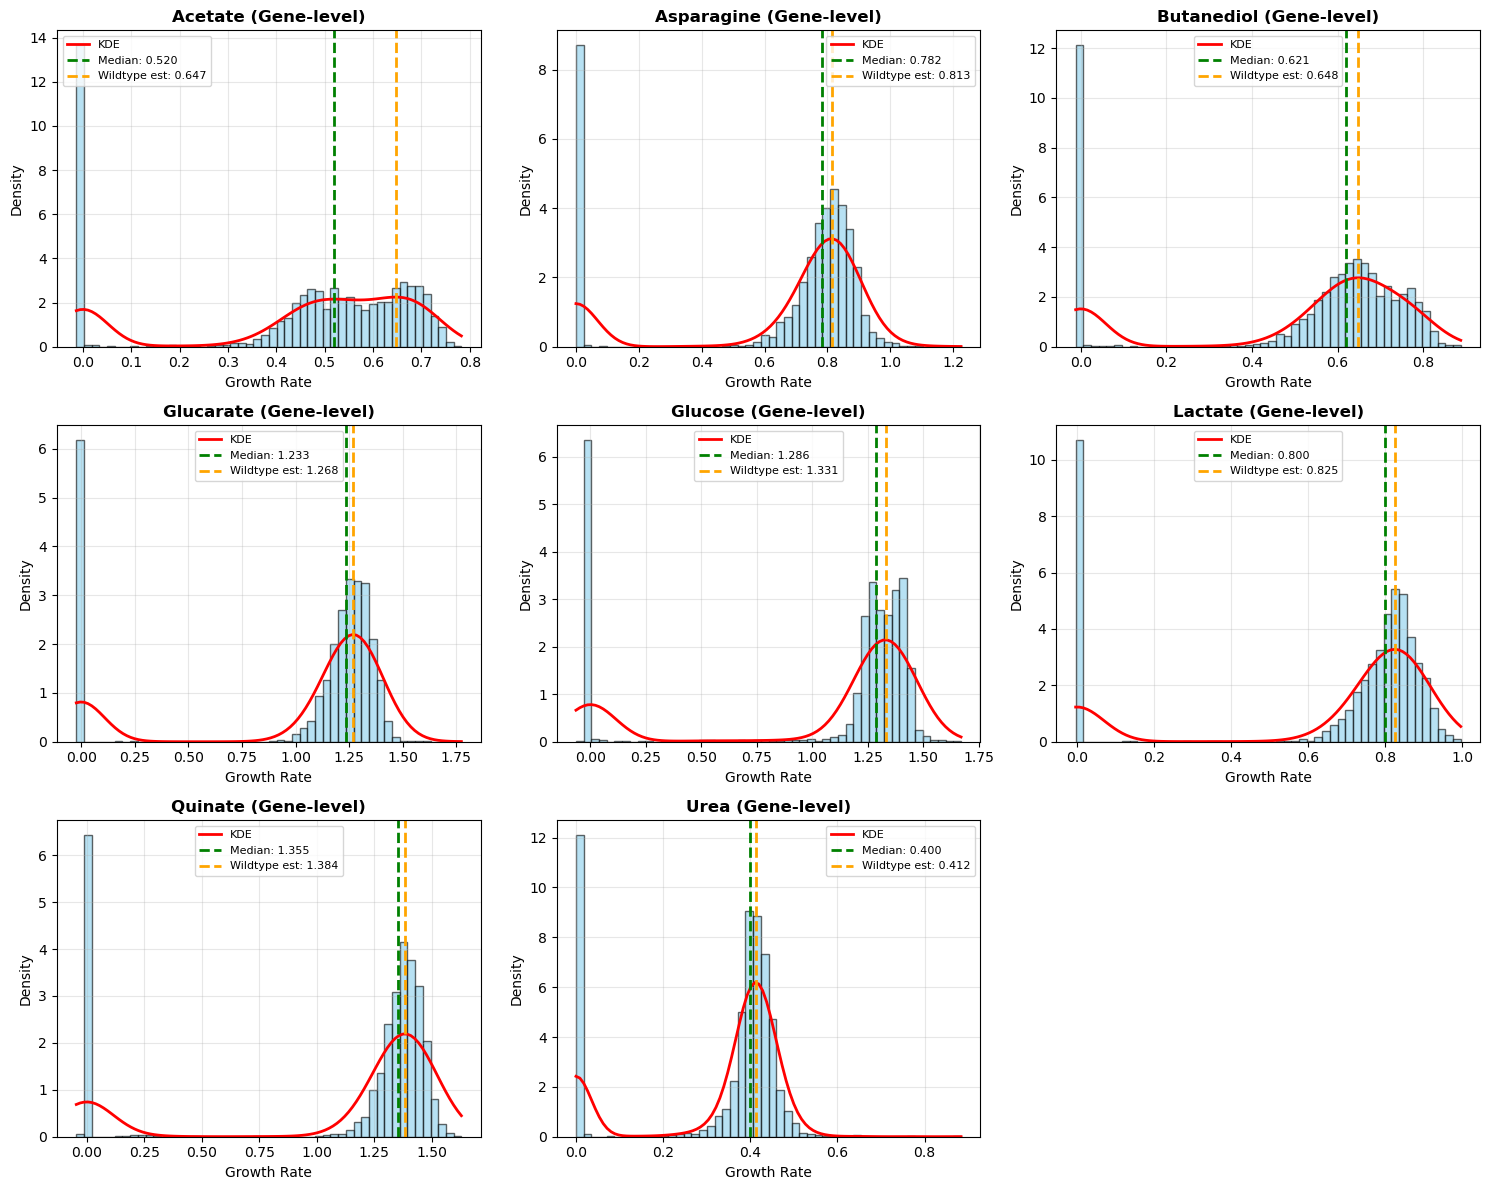

Gene-level distribution plots saved to nboutput/mutant_growth_distributions.png

Creating reaction-level distribution plots...
acetate: 746 reactions with data, median=0.000
asparagine: 751 reactions with data, median=0.000
butanediol: 747 reactions with data, median=0.000
glucarate: 738 reactions with data, median=0.000
glucose: 747 reactions with data, median=0.000
lactate: 750 reactions with data, median=0.000
quinate: 749 reactions with data, median=0.000
urea: 741 reactions with data, median=0.000


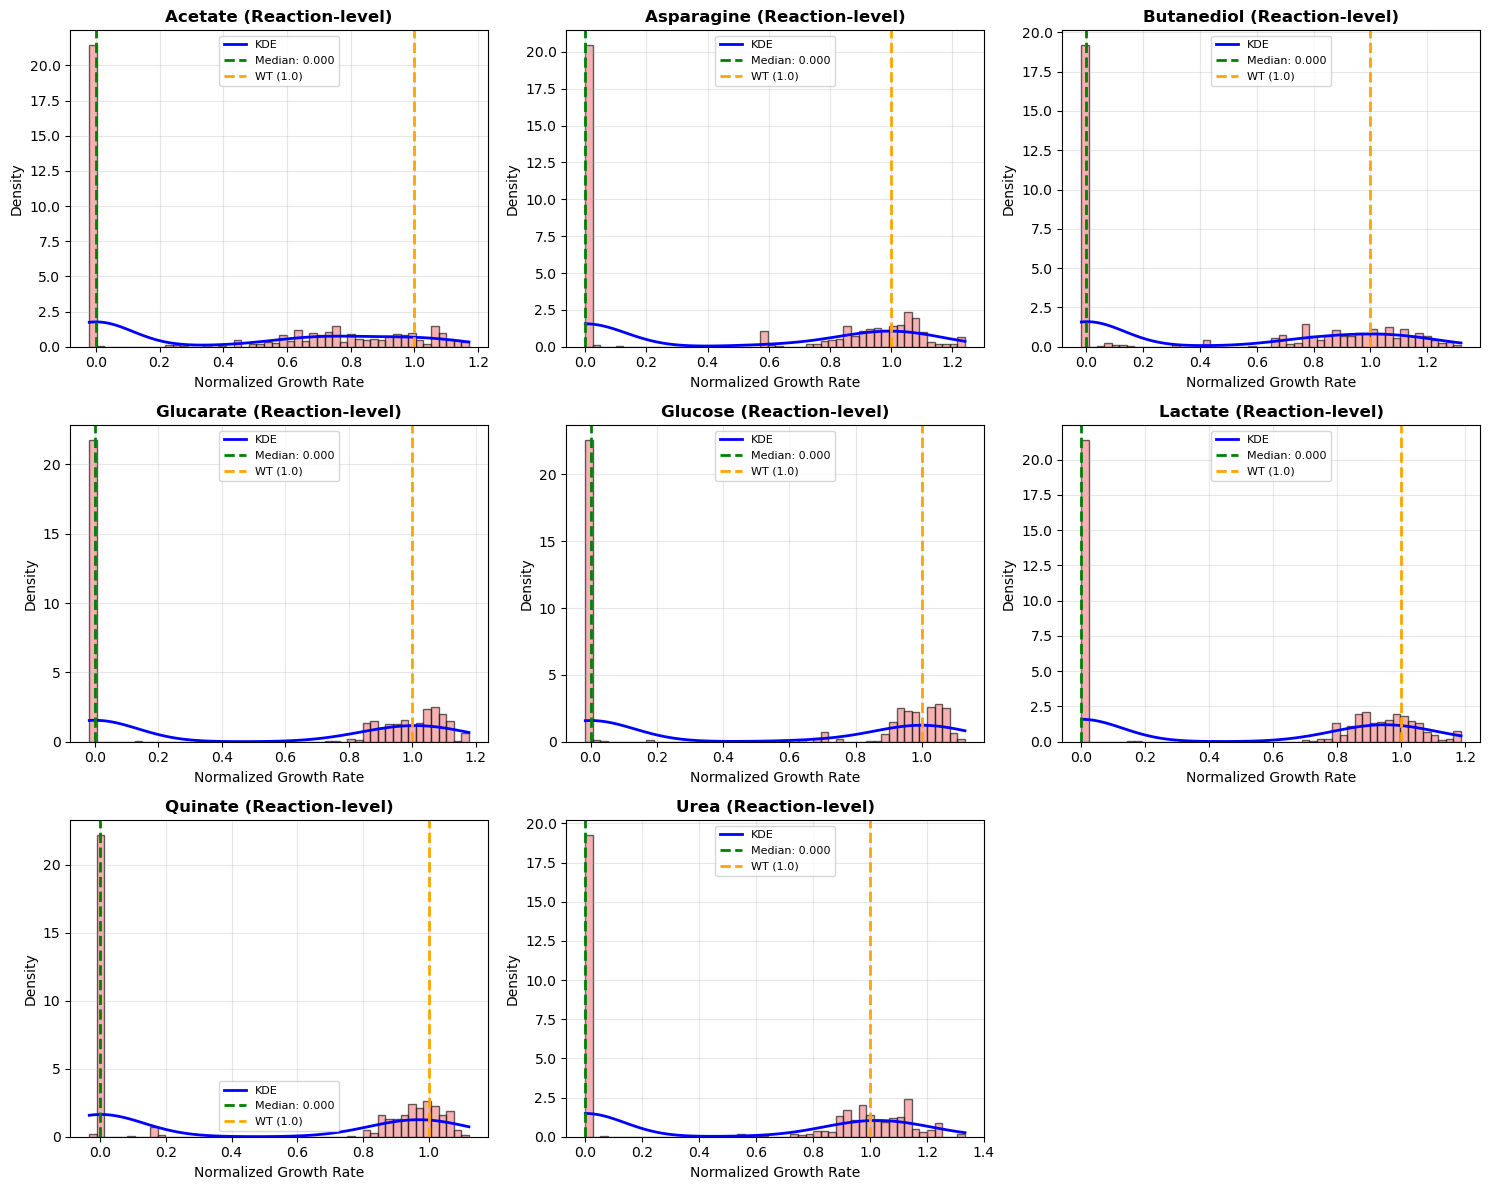


Reaction-level distribution plots saved to nboutput/mutant_growth_distributions_rxn.png


In [2]:
%run util.py

# Create distribution plots for all conditions
data_obj = util.load({"prefix":"ADP1","number_type":"AA","data_type":"MGR"})
data_dict = data_obj.data
df_mutants = pd.DataFrame.from_dict(data_dict, orient='index').T
conditions = util.load(data_obj.name+"-conditions")
analysis_results = util.load(data_obj.name+"-stats")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, condition in enumerate(conditions):
    ax = axes[idx]
    data = df_mutants[condition].dropna()
    
    # Create histogram with KDE
    ax.hist(data, bins=50, alpha=0.6, color='skyblue', edgecolor='black', density=True)
    
    # Add KDE curve
    from scipy import stats
    kde = stats.gaussian_kde(data)
    x_range = np.linspace(data.min(), data.max(), 100)
    ax.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
    
    # Add vertical lines for key statistics
    wildtype_est = analysis_results[condition]['wildtype_estimate']
    ax.axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.3f}')
    ax.axvline(wildtype_est, color='orange', linestyle='--', linewidth=2, label=f'Wildtype est: {wildtype_est:.3f}')
    
    ax.set_xlabel('Growth Rate', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'{condition.capitalize()} (Gene-level)', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Hide the extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig('nboutput/mutant_growth_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Gene-level distribution plots saved to nboutput/mutant_growth_distributions.png")

# Now create distribution plots for reaction-level data (ADP1-NR-RxnMGR)
print("\n" + "=" * 80)
print("Creating reaction-level distribution plots...")

rxn_data_obj = util.load({"prefix":"ADP1","number_type":"NR","data_type":"RxnMGR"})
rxn_data_dict = rxn_data_obj.data

# Convert to DataFrame - data is organized as {condition: {rxn_id: value}}
df_rxn = pd.DataFrame.from_dict(rxn_data_dict, orient='index').T

fig2, axes2 = plt.subplots(3, 3, figsize=(15, 12))
axes2 = axes2.flatten()

for idx, condition in enumerate(conditions):
    ax = axes2[idx]
    if condition in df_rxn.columns:
        data = df_rxn[condition].dropna()
        
        if len(data) > 1:
            # Create histogram with KDE
            ax.hist(data, bins=50, alpha=0.6, color='lightcoral', edgecolor='black', density=True)
            
            # Add KDE curve
            kde = stats.gaussian_kde(data)
            x_range = np.linspace(data.min(), data.max(), 100)
            ax.plot(x_range, kde(x_range), 'b-', linewidth=2, label='KDE')
            
            # Add vertical lines for key statistics
            ax.axvline(data.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {data.median():.3f}')
            ax.axvline(1.0, color='orange', linestyle='--', linewidth=2, label='WT (1.0)')
            
            ax.set_xlabel('Normalized Growth Rate', fontsize=10)
            ax.set_ylabel('Density', fontsize=10)
            ax.set_title(f'{condition.capitalize()} (Reaction-level)', fontsize=12, fontweight='bold')
            ax.legend(fontsize=8)
            ax.grid(True, alpha=0.3)
            
            print(f"{condition}: {len(data)} reactions with data, median={data.median():.3f}")
        else:
            ax.text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{condition.capitalize()} (Reaction-level)', fontsize=12)
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{condition.capitalize()} (Reaction-level)', fontsize=12)

# Hide the extra subplot
axes2[-1].axis('off')

plt.tight_layout()
plt.savefig('nboutput/mutant_growth_distributions_rxn.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nReaction-level distribution plots saved to nboutput/mutant_growth_distributions_rxn.png")

# Create Custom Media for Each Condition

In [ ]:
%run util.py
# Create custom media for each condition based on Carbon-D-Glucose
# Map condition names to carbon source compound IDs
data_obj = util.load({"prefix":"ADP1","number_type":"AA","data_type":"MGR"})
conditions = util.load(data_obj.name+"-conditions")

carbon_source_mapping = {
    'acetate': 'cpd00029',      # Acetate
    'asparagine': 'cpd00132',   # Asparagine
    'butanediol': 'cpd01949',   # 2,3-Butanediol
    'glucarate': 'cpd00571',    # D-Glucarate
    'glucose': 'cpd00027',      # D-Glucose
    'lactate': 'cpd00159',      # Lactate
    'quinate': 'cpd00248',      # Quinate
    'urea': 'cpd00073',  # Urea (nitrogen source, not carbon)
    'succinate': 'cpd00036'          
}

# Get base Carbon-D-Glucose media from KBase
base_media = util.get_media("KBaseMedia/Carbon-D-Glucose",msmedia=True)
print(f"Loaded base media: {base_media.id} with {len(base_media.mediacompounds)} compounds")

# Create custom media for each condition
custom_media = {}
for condition in conditions:
    # Clone the base media
    media_copy = base_media.copy()
    
    # Find and remove D-Glucose if not the target carbon source
    if condition != 'glucose':
        media_copy.remove_compounds(['cpd00027'])
        
        # Add the appropriate carbon source
        carbon_cpd_id = carbon_source_mapping[condition]
        
        # For urea, it's a nitrogen source, so we keep glucose and add urea
        if condition == 'urea':
            # Add succinate
            media_copy.add_compound('cpd00036',-100,10.0,None,"Succinate")  # 10 mM glucose
            # Add urea
            media_copy.add_compound(carbon_cpd_id,-100,10.0,None,"Urea")
            # Remove ammonia
            media_copy.remove_compounds(['cpd00013'])
        else:
            # Replace with new carbon source
            media_copy.add_compound(carbon_cpd_id,-100,10.0,None,condition)

    custom_media[condition] = media_copy.to_dict(output_type="complete")

util.save(data_obj.name+"-media",custom_media)

# Compute Optimal Growth and Set 50% Growth Constraint

In [ ]:
%run util.py
# For each condition, compute optimal growth with dgoa knocked out
# Then set growth constraint to 50% of optimal
data_obj = util.load({"prefix":"ADP1","number_type":"AA","data_type":"MGR"})
conditions = util.load(data_obj.name+"-conditions")

model = MSModelUtil.from_cobrapy("data/FullyTranslatedPublishedModel.json")
custom_media = util.load(data_obj.name+"-media")
optimal_growth_rates = {}

print("Computing optimal growth rates for each condition:")
print("=" * 80)

excluded = ["butanediol","glucose"]
for condition in conditions:
    if condition in excluded:
        continue
    # Set the media
    media = MSMedia.from_dict(custom_media[condition])
    optimal_growth_rates[condition] = util.constrain_objective_to_fraction_of_optimum(model,media=media,objective="MAX{GROWTH_DASH_RXN}",fraction=0.5)
    if optimal_growth_rates[condition] is not None:
        print(f"\n{condition.upper()}:")
        print(f"  Optimal growth: {optimal_growth_rates[condition]:.4f}")
    else:
        print(f"\n{condition.upper()}: No optimal solution found")
        optimal_growth_rates[condition] = 0.0

print("\n" + "=" * 80)

# Save optimal growth rates
util.save(data_obj.name+"-growth",optimal_growth_rates)

# Load Mutant Data into MSExpression and Apply Constraints

In [ ]:
%run util.py

model = MSModelUtil.from_cobrapy("data/FullyTranslatedPublishedModel.json")

# Load phenotype data into dataframe
data_obj = util.load({"prefix":"ADP1","number_type":"AA","data_type":"MGR"})
conditions = util.load(data_obj.name+"-conditions")
custom_media = util.load(data_obj.name+"-media")
data_obj = util.load({"prefix":"ADP1","number_type":"NR","data_type":"MGR"})

# Scale values by wildtype estimate for each condition (convert to normalized ratio matrix)
print("Normalizing phenotype data by wildtype estimates:")
print("=" * 80)

expression = MSExpression.load_from_dict(
    genome_or_model=util.get_msgenome_from_dict(util.load("ADP1Genome")["data"]),
    data_dict=data_obj.data,
    value_type="NormalizedRatios"
)

print(f"\nMSExpression object created:")
# Store results for each condition
msexpression_results = {}
optimal_growth_rates = {}

print("\nApplying MSExpression constraints using fit_model_flux_to_data:")
print("=" * 80)

default_coef_value = 0.01
activation_threshold_value = 0.90
deactivation_threshold_value = 0.95

excluded = ["butanediol","glucose"]
for condition in conditions:
    if condition in excluded:
        continue
    print(f"\n{condition.upper()}:")
    
    # Create a copy of the model for this condition
    import cobra.io
    model_copy = MSModelUtil.from_cobrapy(cobra.io.json.to_json(model.model))
    media = MSMedia.from_dict(custom_media[condition])

    # Set growth constraint
    optimal_growth_rates[condition] = util.constrain_objective_to_fraction_of_optimum(model_copy,media=media,objective="MAX{GROWTH_DASH_RXN}",fraction=0.5)
    
    # Use fit_model_flux_to_data to create constraints
    model_copy.util = util
    result = expression.fit_flux_to_mutant_growth_rate_data(
        model=model_copy,
        condition=condition,
        default_coef=default_coef_value,
        activation_threshold=activation_threshold_value,
        deactivation_threshold=deactivation_threshold_value,
        use_activation_constraints=False
    )
    util.constrain_objective_to_fraction_of_optimum(model_copy,media=media,objective="MAX{GROWTH_DASH_RXN}",fraction=0)
    model_copy.printlp(print=True,path="models/lpfiles/",filename=condition)
    output = util.analyzed_reaction_objective_coupling(model_copy,result["solution"],biomass_objective_coupling=True,biomass_id="GROWTH_DASH_RXN")
    
    # Initialize the reduced lists
    output["on_on_reduced"] = []
    output["off_on_reduced"] = []
    output["none_on_reduced"] = []
    
    for rxn in model_copy.model.reactions:
        rxn_id = rxn.id
        if rxn_id in output["reaction_objective_coupling"] and "objective_ratio" in output["reaction_objective_coupling"][rxn_id]:
            if rxn_id in result["on_on"] or rxn_id in result["on_off"]:
                print(f"  {rxn_id} is on in on_on or on_off with objective ratio {output['reaction_objective_coupling'][rxn_id]['objective_ratio']}")
                output["reaction_objective_coupling"][rxn_id]["expression_data_status"] = "on"
                if output["reaction_objective_coupling"][rxn_id]["objective_ratio"] < 0.95:
                    output["on_on_reduced"].append(rxn_id)
            elif rxn_id in result["off_on"] or rxn_id in result["off_off"]:
                print(f"  {rxn_id} is on in off_on or off_off with objective ratio {output['reaction_objective_coupling'][rxn_id]['objective_ratio']}")
                output["reaction_objective_coupling"][rxn_id]["expression_data_status"] = "off"
                if output["reaction_objective_coupling"][rxn_id]["objective_ratio"] < 0.95:
                    output["off_on_reduced"].append(rxn_id)
            else:
                print(f"  {rxn_id} is on in none_on or none_off with objective ratio {output['reaction_objective_coupling'][rxn_id]['objective_ratio']}")
                output["reaction_objective_coupling"][rxn_id]["expression_data_status"] = "none"
                if output["reaction_objective_coupling"][rxn_id]["objective_ratio"] < 0.95:
                    output["none_on_reduced"].append(rxn_id)

    # fit_model_flux_to_data returns a dictionary with 'solution' and 'constraints'
    if isinstance(result, dict) and 'solution' in result:
        solution = result['solution']
        if solution.status == 'optimal':
            print(f"  FBA with expression constraints successful")
            print(f"  Growth rate: {solution.objective_value:.4f}")

            # Store results
            msexpression_results[condition] = {
                "fluxes": solution.fluxes.to_dict(),
                'growth_rate': solution.fluxes["GROWTH_DASH_RXN"],
                'fraction': solution.fluxes["GROWTH_DASH_RXN"]/optimal_growth_rates[condition],
                'status': solution.status,
                'on_on': result['on_on'],
                'on_off': result['on_off'],
                'off_on': result['off_on'],
                'off_off': result['off_off'],
                'none_on': result['none_on'],
                'none_off': result['none_off'],
                'baseline_growth': output['baseline_objective_value'],
                'essential_count': output['essential_count'],
                'reduced_count': output['reduced_count'],
                'reaction_objective_coupling': output["reaction_objective_coupling"],
                'on_on_reduced': output["on_on_reduced"],
                'off_on_reduced': output["off_on_reduced"],
                'none_on_reduced': output["none_on_reduced"],
                'unconstrained_baseline_growth': output['unconstrained_baseline_objective_value'],
                'unconstrained_essential_count': output['unconstrained_essential_count'],
                'unconstrained_reduced_count': output['unconstrained_reduced_count']
            }
            util.save("FittingMutantPhenotypeData",msexpression_results)
        else:
            print(f"  FBA failed: {solution.status}")
            msexpression_results[condition] = {
                'status': solution.status
            }
    else:
        print(f"  Unexpected result type: {type(result)}")
        msexpression_results[condition] = {
            'status': 'error'
        }
print("\n" + "=" * 80)

# Save MSExpression results
util.save(data_obj.name+"-MGR-Fit"+str(default_coef_value)+","+str(activation_threshold_value)+","+str(deactivation_threshold_value),msexpression_results)

print("\nMSExpression results saved to datacache/msexpression_results.json")

/Users/chenry/Dropbox/Projects/KBUtilLib/src
modelseedpy 0.4.2


2025-12-29 00:33:56,508 - __main__.NotebookUtil - INFO - Loaded configuration from: /Users/chenry/.kbutillib/config.yaml
2025-12-29 00:33:56,508 - __main__.NotebookUtil - INFO - Loaded 0 tokens from /Users/chenry/.tokens
2025-12-29 00:33:56,509 - __main__.NotebookUtil - INFO - Loaded kbase tokens from /Users/chenry/.kbase/token


loading biochemistry database from /Users/chenry/Dropbox/Projects/ModelSEEDDatabase


2025-12-29 00:34:01,355 - __main__.NotebookUtil - INFO - ModelSEED database loaded from /Users/chenry/Dropbox/Projects/ModelSEEDDatabase
2025-12-29 00:34:01,756 - __main__.NotebookUtil - WARNING - BLAST tools not found. Install NCBI BLAST+ to use BLAST functionality. On Ubuntu/Debian: sudo apt-get install ncbi-blast+, On MacOS: brew install blast
2025-12-29 00:34:01,757 - __main__.NotebookUtil - INFO - Notebook environment detected
2025-12-29 00:34:01,758 - __main__.NotebookUtil - INFO - ArgoGatewayClient initialised | model=gpto3mini env=dev timeout=120.0s url=https://apps-dev.inside.anl.gov/argoapi/api/v1/resource/streamchat/


cobrakbase 0.4.0
/Users/chenry/.npm-global/bin/claude


2025-12-29 00:34:02,249 - __main__.NotebookUtil - INFO - AICurationUtils initialized with backend: claude-code


Normalizing phenotype data by wildtype estimates:


INFO:modelseedpy.core.msmodelutl:cpd00099 not found in model!



MSExpression object created:

Applying MSExpression constraints using fit_model_flux_to_data:

ACETATE:


INFO:modelseedpy.core.msmodelutl:cpd00063 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00058 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00034 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00030 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00205 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00254 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd10516 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd11574 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00244 not found in model!


On: {'rxn00947_c0': 3.7061309668676268, 'rxn00100_c0': 10.0, 'rxn00305_c0': 10.0, 'rxn04783_c0': 4.484034961904871, 'rxn15467_c0': 4.9356007794810886, 'rxn00199_c0': 10.0, 'rxn01353_c0': 5.638912087411652, 'rxn03887_c0': 3.2878633866223055, 'rxn00338_c0': 10.0, 'rxn07577_c0': 10.0, 'rxn01974_c0': 10.0, 'rxn00990_c0': 2.9535289967163894, 'rxn08353_c0': 10.0, 'rxn00867_c0': 2.894921008690363, 'rxn12232_c0': 1.512263852736532, 'rxn12494_c0': 4.761105654572596, 'rxn02011_c0': 10.0, 'rxn00929_c0': 10.0, 'rxn02834_c0': 10.0, 'rxn12280_c0': 2.5512538413608468, 'rxn12393_c0': 10.0, 'rxn05350_c0': 10.0, 'rxn00205_c0': 3.391767793551124, 'rxn03908_c0': 10.0, 'rxn01106_c0': 10.0, 'rxn08861_c0': 10.0, 'rxn03137_c0': 10.0, 'rxn08291_c0': 2.1636345459163735, 'rxn20547_c0': 10.0, 'rxn00737_c0': 10.0, 'rxn20472_c0': 10.0, 'rxn12241_c0': 10.0, 'rxn00187_c0': 10.0, 'rxn02302_c0': 10.0, 'rxn03907_c0': 10.0, 'rxn12240_c0': 10.0, 'rxn12247_c0': 10.0, 'rxn12356_c0': 2.139653634390828, 'rxn12364_c0': 1.87990

INFO:modelseedpy.core.msmodelutl:cpd00099 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00063 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00058 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00034 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00030 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00205 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00254 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd10516 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd11574 not found in model!
INFO:modelseedpy.core.msmodelutl:cpd00244 not found in model!
2025-12-29 00:34:03,973 - __main__.NotebookUtil - INFO - Zero-flux reactions: 552
2025-12-29 00:34:03,973 - __main__.NotebookUtil - INFO - Active reactions: 438
2025-12-29 00:34:03,974 - __main__.NotebookUtil - INFO - Building flexible biomass package


1.0*GROWTH_DASH_RXN - 1.0*GROWTH_DASH_RXN_reverse_6bca6
Baseline objective: 1.0*GROWTH_DASH_RXN - 1.0*GROWTH_DASH_RXN_reverse_6bca6


/opt/anaconda3/envs/modelseed/lib/python3.9/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Unconstrained baseline objective: 1.0*GROWTH_DASH_RXN - 1.0*GROWTH_DASH_RXN_reverse_6bca6
Unconstrained rxn12357_c0 KO objective: 1.0*GROWTH_DASH_RXN - 1.0*GROWTH_DASH_RXN_reverse_6bca6
Unconstrained rxn00947_c0 KO objective: 1.0*GROWTH_DASH_RXN - 1.0*GROWTH_DASH_RXN_reverse_6bca6
Unconstrained rxn00100_c0 KO objective: 1.0*GROWTH_DASH_RXN - 1.0*GROWTH_DASH_RXN_reverse_6bca6
Unconstrained rxn00305_c0 KO objective: 1.0*GROWTH_DASH_RXN - 1.0*GROWTH_DASH_RXN_reverse_6bca6
Unconstrained rxn04783_c0 KO objective: 1.0*GROWTH_DASH_RXN - 1.0*GROWTH_DASH_RXN_reverse_6bca6
Unconstrained rxn15467_c0 KO objective: 1.0*GROWTH_DASH_RXN - 1.0*GROWTH_DASH_RXN_reverse_6bca6
Unconstrained rxn12353_c0 KO objective: 1.0*GROWTH_DASH_RXN - 1.0*GROWTH_DASH_RXN_reverse_6bca6
Unconstrained rxn06556_c0 KO objective: 1.0*GROWTH_DASH_RXN - 1.0*GROWTH_DASH_RXN_reverse_6bca6
Unconstrained rxn00338_c0 KO objective: 1.0*GROWTH_DASH_RXN - 1.0*GROWTH_DASH_RXN_reverse_6bca6
Unconstrained rxn01974_c0 KO objective: 1.0*GR

# Expression-Flux Statistics Analysis

Compute high-level statistics comparing expression state to flux activity and essentiality for each condition.

In [2]:
%run util.py

def compute_expression_flux_statistics(condition_data):
    """
    Compute high-level statistics for a condition comparing expression state
    to flux activity and essentiality for all expression categories (on, off, none).
    
    For each expression category:
    - What fraction are active ("on") in the flux solution?
    - Of those active, what fraction are essential or reduced in the KO analysis?
    
    Returns a dictionary with statistics for all categories.
    """
    # Get expression category lists
    on_on = condition_data.get('on_on', [])    # Expression "on" AND flux active
    on_off = condition_data.get('on_off', [])  # Expression "on" BUT flux inactive
    off_on = condition_data.get('off_on', [])  # Expression "off" BUT flux active
    off_off = condition_data.get('off_off', [])  # Expression "off" AND flux inactive
    none_on = condition_data.get('none_on', [])  # No expression data, flux active
    none_off = condition_data.get('none_off', [])  # No expression data, flux inactive
    
    # Get reaction_objective_coupling data
    roc = condition_data.get('reaction_objective_coupling', {})
    
    def compute_category_stats(expr_status, active_list, inactive_list):
        """Helper to compute stats for a single expression category."""
        total = len(active_list) + len(inactive_list)
        fraction_active = len(active_list) / total if total > 0 else 0
        
        # Get reactions in this category from reaction_objective_coupling
        rxns_in_roc = {rxn: d for rxn, d in roc.items() if d.get('expression_data_status') == expr_status}
        total_in_roc = len(rxns_in_roc)
        
        # Constrained solution analysis
        essential_constrained = sum(1 for d in rxns_in_roc.values() if d.get('impact') == 'essential')
        reduced_constrained = sum(1 for d in rxns_in_roc.values() if d.get('impact') == 'reduced')
        dispensable_constrained = sum(1 for d in rxns_in_roc.values() if d.get('impact') == 'dispensable')
        
        # Unconstrained solution analysis
        essential_unconstrained = sum(1 for d in rxns_in_roc.values() if d.get('unconstrained_impact') == 'essential')
        reduced_unconstrained = sum(1 for d in rxns_in_roc.values() if d.get('unconstrained_impact') == 'reduced')
        dispensable_unconstrained = sum(1 for d in rxns_in_roc.values() if d.get('unconstrained_impact') == 'dispensable')
        
        return {
            "total": total,
            "flux_active": len(active_list),
            "flux_inactive": len(inactive_list),
            "fraction_flux_active": round(fraction_active, 4),
            "active_in_ko_analysis": total_in_roc,
            "constrained": {
                "essential_count": essential_constrained,
                "reduced_count": reduced_constrained,
                "dispensable_count": dispensable_constrained,
                "essential_fraction": round(essential_constrained / total_in_roc, 4) if total_in_roc > 0 else 0,
                "reduced_fraction": round(reduced_constrained / total_in_roc, 4) if total_in_roc > 0 else 0,
                "essential_or_reduced_fraction": round((essential_constrained + reduced_constrained) / total_in_roc, 4) if total_in_roc > 0 else 0
            },
            "unconstrained": {
                "essential_count": essential_unconstrained,
                "reduced_count": reduced_unconstrained,
                "dispensable_count": dispensable_unconstrained,
                "essential_fraction": round(essential_unconstrained / total_in_roc, 4) if total_in_roc > 0 else 0,
                "reduced_fraction": round(reduced_unconstrained / total_in_roc, 4) if total_in_roc > 0 else 0,
                "essential_or_reduced_fraction": round((essential_unconstrained + reduced_unconstrained) / total_in_roc, 4) if total_in_roc > 0 else 0
            }
        }
    
    stats = {
        "on": compute_category_stats("on", on_on, on_off),
        "off": compute_category_stats("off", off_on, off_off),
        "none": compute_category_stats("none", none_on, none_off)
    }
    
    return stats

# Load the mutant phenotype analysis results
data_obj = util.load({"prefix":"ADP1","number_type":"NR","data_type":"MGR"})

# Find the most recent MGRFit file
import glob
import os
fit_files = glob.glob("datacache/ADP1-NR-MGR-MGR-Fit*.json")
if fit_files:
    # Sort by modification time to get the most recent
    fit_files.sort(key=os.path.getmtime, reverse=True)
    selected_file = fit_files[0]
    print(f"Loading results from: {os.path.basename(selected_file)}")
    
    with open(selected_file, 'r') as f:
        fit_data = json.load(f)
else:
    print("No MGRFit files found!")
    fit_data = {}

# Compute and add statistics to each condition
for condition in fit_data.keys():
    if 'fluxes' not in fit_data[condition]:
        continue
    stats = compute_expression_flux_statistics(fit_data[condition])
    fit_data[condition]['expression_flux_statistics'] = stats

# Display results for each expression category
for expr_category in ["on", "off", "none"]:
    print("\n" + "=" * 100)
    print(f"EXPRESSION '{expr_category.upper()}' REACTIONS - FLUX AND ESSENTIALITY STATISTICS")
    print("=" * 100)
    print(f"\n{'Condition':<12} {'Total':<8} {'Active':<8} {'%Active':<10} {'Const Ess%':<12} {'Const Red%':<12} {'Unc Ess%':<12} {'Unc Red%':<10}")
    print("-" * 100)
    
    for condition in fit_data.keys():
        if 'expression_flux_statistics' not in fit_data[condition]:
            continue
        
        stats = fit_data[condition]['expression_flux_statistics'][expr_category]
        const = stats['constrained']
        unconst = stats['unconstrained']
        
        print(f"{condition:<12} {stats['total']:<8} {stats['flux_active']:<8} "
              f"{stats['fraction_flux_active']*100:>6.1f}%    "
              f"{const['essential_fraction']*100:>6.1f}%      "
              f"{const['reduced_fraction']*100:>6.1f}%      "
              f"{unconst['essential_fraction']*100:>6.1f}%      "
              f"{unconst['reduced_fraction']*100:>6.1f}%")

print("\n" + "=" * 100)
print("STATISTICS EXPLANATION:")
print("=" * 100)
print("  - Total: Total reactions in this expression category")
print("  - Active: Reactions with non-zero flux in the solution")
print("  - %Active: Fraction of reactions in category that have non-zero flux")
print("  - Const Ess%: Fraction of active reactions that are essential (constrained solution)")
print("  - Const Red%: Fraction of active reactions with reduced growth when knocked out (constrained)")
print("  - Unc Ess%: Fraction of active reactions that are essential (unconstrained solution)")
print("  - Unc Red%: Fraction of active reactions with reduced growth when knocked out (unconstrained)")
print("\nExpression categories:")
print("  - 'on': Reactions with high expression/growth rate data (expected to be active)")
print("  - 'off': Reactions with low expression/growth rate data (expected to be inactive)")
print("  - 'none': Reactions with no expression data available")

# Save updated results with statistics
if selected_file:
    with open(selected_file, 'w') as f:
        json.dump(fit_data, f, indent=4)
    print(f"\nUpdated results saved to: {os.path.basename(selected_file)}")

2025-12-29 00:47:31,987 - __main__.NotebookUtil - INFO - Loaded configuration from: /Users/chenry/.kbutillib/config.yaml
2025-12-29 00:47:31,987 - __main__.NotebookUtil - INFO - Loaded 0 tokens from /Users/chenry/.tokens
2025-12-29 00:47:31,988 - __main__.NotebookUtil - INFO - Loaded kbase tokens from /Users/chenry/.kbase/token
2025-12-29 00:47:31,989 - __main__.NotebookUtil - INFO - ModelSEED database loaded from /Users/chenry/Dropbox/Projects/ModelSEEDDatabase


/Users/chenry/Dropbox/Projects/KBUtilLib/src


2025-12-29 00:47:32,370 - __main__.NotebookUtil - WARNING - BLAST tools not found. Install NCBI BLAST+ to use BLAST functionality. On Ubuntu/Debian: sudo apt-get install ncbi-blast+, On MacOS: brew install blast
2025-12-29 00:47:32,371 - __main__.NotebookUtil - INFO - Notebook environment detected
2025-12-29 00:47:32,372 - __main__.NotebookUtil - INFO - ArgoGatewayClient initialised | model=gpto3mini env=dev timeout=120.0s url=https://apps-dev.inside.anl.gov/argoapi/api/v1/resource/streamchat/


/Users/chenry/.npm-global/bin/claude


2025-12-29 00:47:32,854 - __main__.NotebookUtil - INFO - AICurationUtils initialized with backend: claude-code


Loading results from: ADP1-NR-MGR-MGR-Fit0.01,0.9,0.95.json

EXPRESSION 'ON' REACTIONS - FLUX AND ESSENTIALITY STATISTICS

Condition    Total    Active   %Active    Const Ess%   Const Red%   Unc Ess%     Unc Red%  
----------------------------------------------------------------------------------------------------
acetate      605      346        57.2%      96.8%         3.2%        57.8%         0.6%

EXPRESSION 'OFF' REACTIONS - FLUX AND ESSENTIALITY STATISTICS

Condition    Total    Active   %Active    Const Ess%   Const Red%   Unc Ess%     Unc Red%  
----------------------------------------------------------------------------------------------------
acetate      107      4           3.7%     100.0%         0.0%        75.0%         0.0%

EXPRESSION 'NONE' REACTIONS - FLUX AND ESSENTIALITY STATISTICS

Condition    Total    Active   %Active    Const Ess%   Const Red%   Unc Ess%     Unc Red%  
--------------------------------------------------------------------------------------------